This file contains python code to mimic real setting

It is under the logi setting

Now, I use the same beta and X is raw MEG

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from pprint import pprint
import itertools
from scipy.stats import chi2


In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from hdf_utils.data_gen import gen_simu_meg_dataset
from hdf_utils.SIS import SIS_GLIM
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_obasis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.opt import HDFOpt
from scenarios.real_simu_logi_meg import settings
from hdf_utils.fns_sinica import  fourier_basis_fn

from joblib import Parallel, delayed

In [5]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

# Params

In [6]:
AD_ts = load_pkl(DATA_ROOT/"AD_vs_Ctrl_ts/AD88_all.pkl")
Ctrl_ts = load_pkl(DATA_ROOT/"AD_vs_Ctrl_ts/Ctrl92_all.pkl")
ts_data = np.concatenate([AD_ts, Ctrl_ts], axis=0)
stds = ts_data.std(axis=(1, 2));
ts_data_filter = ts_data[np.sort(np.where(stds>100)[0])];

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../data/AD_vs_Ctrl_ts/AD88_all.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../data/AD_vs_Ctrl_ts/Ctrl92_all.pkl


In [27]:
np.random.seed(0)
c = 0.4

setting = settings.nm2
data_gen_params = setting.data_gen_params
data_gen_params.cs = data_gen_params.cs_fn(c)
data_gen_params.gt_beta = data_gen_params.beta_fn(data_gen_params.cs)

num_rep = 200
Cmat = np.eye(data_gen_params.d - len(setting.sel_idx))
save_dir = RES_ROOT/f"simu_logi_setting{setting.setting}_test"
if not save_dir.exists():
    save_dir.mkdir()
Cmat

array([[1., 0.],
       [0., 1.]])

In [28]:
def _get_logi_int(data_gen_params, n_jobs=30, num_rep=100):
    ress = []
    for inte in tqdm(data_gen_params.intercept_cans):
        gt_alp = np.concatenate([[inte], data_gen_params.gt_alp0])
        def _run_fn(seed, data_gen_params=data_gen_params):
            data = gen_simu_meg_dataset(n=data_gen_params.n, 
                                        q=data_gen_params.q, 
                                        types_=data_gen_params.types_, 
                                        gt_alp=gt_alp, 
                                        gt_beta=data_gen_params.gt_beta, 
                                        npts=data_gen_params.npts, 
                                        base_data=ts_data_filter,
                                        data_type=data_gen_params.data_type, 
                                        data_params=data_gen_params.data_params, 
                                        seed=seed, 
                                        verbose=1)
            return data.Y.numpy()
        with Parallel(n_jobs=n_jobs) as parallel:
            res = parallel(delayed(_run_fn)(seed) for seed in range(num_rep))
        ress.append(np.array(res))


    # get the intercept
    Yms = np.array([res.mean() for res in ress])
    intercept = data_gen_params.intercept_cans[np.argmin(np.abs(Yms-0.5))]
    print(f"The mean of Y is {Yms[np.argmin(np.abs(Yms-0.5))]:.3f} under intercept {intercept:.3f}.")
    gt_alp = np.concatenate([[intercept], data_gen_params.gt_alp0])
    return gt_alp

In [29]:
#data_gen_params.gt_alp = _get_logi_int(data_gen_params, 20);
data_gen_params.gt_alp = np.array([-0.64, -1, 2])

100%|██████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 35.96it/s]


Text(0.5, 1.0, '[0.045 0.14  0.045 0.175 0.16  0.04  1.   ]')

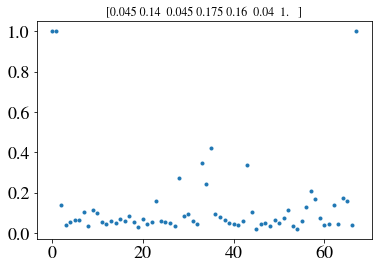

In [30]:
def _SIS_fn(seed, SIS_ratio, N, SIS_pen, setting):
    torch.set_default_dtype(torch.double)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    data_gen_params = edict(setting.data_gen_params.copy())
    basis_mat = torch.tensor(obt_bsp(np.linspace(0, 1, data_gen_params.npts), N, 4)).to(torch.get_default_dtype())
    cur_data = gen_simu_meg_dataset(n=data_gen_params.n, 
                                   q=data_gen_params.q, 
                                   types_=data_gen_params.types_, 
                                   gt_alp=data_gen_params.gt_alp, 
                                   gt_beta=data_gen_params.gt_beta, 
                                   npts=data_gen_params.npts, 
                                   base_data=ts_data_filter, 
                                   data_type=data_gen_params.data_type,
                                   data_params=data_gen_params.data_params, 
                                   seed=seed, 
                                   verbose=2);
    
    keep_idxs, _  = SIS_GLIM(Y=cur_data.Y, X=cur_data.X, Z=cur_data.Z, 
                             basis_mat=basis_mat, keep_ratio=SIS_ratio, 
                             model_type=setting.model_type, SIS_pen=SIS_pen, sel_idx=setting.sel_idx)
    M_idxs = np.delete(np.arange(data_gen_params.d), setting.sel_idx)
    keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
    return keep_idxs
obt_bsp = obt_bsp_obasis_Rfn
num_rep = 200
with Parallel(n_jobs=30) as parallel:
    keep_idxss = parallel(delayed(_SIS_fn)(seed, 0.10, N=10, SIS_pen=5, setting=setting) for seed in 
                          tqdm(range(0, num_rep), total=num_rep))
vs, cts = np.unique(np.concatenate(keep_idxss), return_counts=1);
cts = cts[np.argsort(vs)]/len(keep_idxss)
vs = np.sort(vs);
plt.plot(vs, cts, ".")
plt.title(f"{cts[vs > 60]}")

# Simu

## Check data gen fn

In [13]:
data = gen_simu_meg_dataset(
    n=data_gen_params.n, 
    q=data_gen_params.q, 
    types_=data_gen_params.types_, 
    gt_alp=data_gen_params.gt_alp, 
    gt_beta=data_gen_params.gt_beta, 
    npts=data_gen_params.npts, 
    base_data =ts_data_filter,
    data_type=data_gen_params.data_type,
    data_params=data_gen_params.data_params, 
    seed=1, 
    verbose=2);

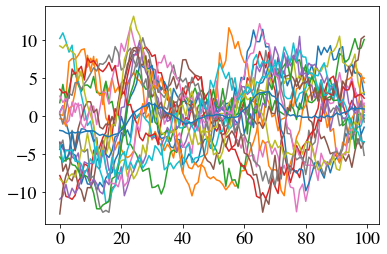

In [14]:
sub_idx = 10
for roi_ix in range(20):
    plt.plot(data.X[sub_idx, roi_ix, :])
plt.plot(data.X[sub_idx, :, :].mean(axis=0))

In [15]:
data.Y.mean()

tensor(0.5480)

## Simulation

In [13]:
def _run_fn(seed, lam, N, setting, is_save=False, is_cv=False, verbose=2):
    """Now (on Aug 25, 2023), if we keep seed the same, the cur_data is the same. 
       If you want to make any changes, make sure this. 
    """
    torch.set_default_dtype(torch.double)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    _setting = edict(setting.copy())
    _setting.seed = seed
    _setting.lam = lam
    _setting.N = N
    
    data_gen_params = setting.data_gen_params
    
    f_name = f"seed_{seed:.0f}-lam_{lam*1000:.0f}-N_{N:.0f}_fit.pkl"
    
    
    if not (save_dir/f_name).exists():
        cur_data = gen_simu_meg_dataset(n=data_gen_params.n, 
                                   q=data_gen_params.q, 
                                   types_=data_gen_params.types_, 
                                   gt_alp=data_gen_params.gt_alp, 
                                   gt_beta=data_gen_params.gt_beta, 
                                   npts=data_gen_params.npts, 
                                   base_data=ts_data_filter, 
                                   data_type=data_gen_params.data_type,
                                   data_params=data_gen_params.data_params, 
                                   seed=seed, 
                                   verbose=verbose);
        hdf_fit = HDFOpt(lam=_setting.lam, 
                         sel_idx=_setting.sel_idx, 
                         model_type=_setting.model_type,
                         verbose=verbose, 
                         SIS_ratio=_setting.SIS_ratio, 
                         N=_setting.N,
                         is_std_data=True, 
                         cov_types=None, 
                         inits=None,
                         model_params = _setting.model_params, 
                         SIS_params = _setting.SIS_params, 
                         opt_params = _setting.opt_params,
                         bsp_params = _setting.bsp_params, 
                         pen_params = _setting.pen_params
               );
        hdf_fit.add_data(cur_data.X, cur_data.Y, cur_data.Z)
        opt_res = hdf_fit.fit()
        
        if is_cv:
            hdf_fit.get_cv_est(_setting.num_cv_fold)
        if is_save:
            hdf_fit.save(save_dir/f_name, is_compact=False, is_force=True)
    else:
        hdf_fit = load_pkl(save_dir/f_name, verbose>=2);
        
    return hdf_fit


### single test

In [17]:
seed = 0
lam = 0.2
N = 6
setting.bsp_params.is_orth_basis = True
setting.SIS_ratio = 0.2
res = _run_fn(seed=seed, lam=lam, N=N, setting=setting, is_cv=False, is_save=False, verbose=2)

2024-01-30 15:48:23,315 - optimization.opt - INFO - opt parmas is {'stop_cv': 0.0005, 'max_iter': 2000, 'one_step_verbose': 0, 'alpha': 0.9, 'beta': 1.5, 'R': 200000.0, 'N_eps': 0.0001, 'N_maxit': 100, 'is_BFGS': 'adaptive'}.
2024-01-30 15:48:23,315 - optimization.opt - INFO - SIS parmas is {'SIS_pen': 5, 'SIS_basis_N': 10, 'SIS_basis_ord': 4, 'SIS_ratio': 0.2}.
2024-01-30 15:48:23,316 - optimization.opt - INFO - model parmas is {}.
2024-01-30 15:48:23,317 - optimization.opt - INFO - penalty parmas is {'a': 3.7, 'lam': 0.2}.
2024-01-30 15:48:23,317 - optimization.opt - INFO - bspline parmas is {'basis_ord': 4, 'is_orth_basis': True, 'N': 6}.
2024-01-30 15:48:23,318 - optimization.opt - INFO - As cov_types is not provided, inferring the continuous covariates.
R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


Main Loop:  10%|██▍                       | 191/2000 [00:04<00:43, 41.28i

In [18]:
res.est_alp

tensor([-0.5189, -0.5876,  1.7300])

In [19]:
res.X[0, 1].mean()

tensor(-0.1580)

In [20]:
Cmat = np.array([1]).reshape(1, -1)
ts = setting.data_gen_params.gt_beta[:, :1];
res.hypo_test(Cmat, ts=None)

2024-01-30 15:48:32,618 - optimization.opt - INFO - hypo parmas is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[1]])}.


{'pval': 0.9196348417137842, 'T_v': tensor(2.0007)}

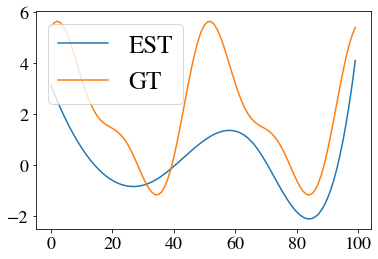

In [21]:
est_beta = res.basis_mat @ res.est_Gam
gt_beta = setting.data_gen_params.gt_beta[:, res.keep_idxs]
idx = -1
plt.plot(est_beta[:, idx], label="EST")
plt.plot(gt_beta[:, idx], label="GT")
plt.legend()

### Multipe test

In [14]:
def outlier_det(T_vs, ratio_tol=0.05):
    """
    Detects outliers in a given dataset using the interquartile range (IQR) method.

    Parameters:
    - T_vs (array-like): The input dataset.
    - ratio_tol (float, optional): The tolerance ratio for outlier removal. Default is 0.05.

    Returns:
    - kpidx (ndarray): A boolean array indicating whether each data point is an outlier or not.
    """
    Q1, Q3 = np.quantile(T_vs, [0.25, 0.75])
    IQR = Q3 - Q1
    upbd = Q3 + 1.5*IQR
    lowbd = Q1 - 1.5*IQR
    kpidx = np.bitwise_and(T_vs>=lowbd, T_vs<=upbd)
    
    if np.mean(kpidx)+ ratio_tol < 1:
        out_part = np.stack([T_vs - upbd, lowbd - T_vs]).T.max(axis=1);
        kpidx = np.ones(len(T_vs), dtype=bool)
        kpidx[np.argsort(-out_part)[:int(len(T_vs)*ratio_tol)]] = False
    return kpidx

In [31]:
c = 0
setting = settings.nm1
data_gen_params = setting.data_gen_params
data_gen_params.cs = data_gen_params.cs_fn(c)
data_gen_params.gt_beta = data_gen_params.beta_fn(data_gen_params.cs)
#data_gen_params.n = 200
setting.opt_params.beta = 0.5
#setting.bsp_params.is_orth_basis = True
#setting.pen_params.a = 3.7
#setting.SIS_ratio = 0.2
#setting.SIS_params.SIS_basis_N = 10
#setting.SIS_params.SIS_pen = 5

save_dir = RES_ROOT/f"simu_logi_setting{setting.setting}_test"
if not save_dir.exists():
    save_dir.mkdir()
    
Cmat = np.eye(1)
#Cmat = np.array([1, -1]).reshape(1, -1)
print(Cmat.shape)
ts = setting.data_gen_params.beta_fn(setting.data_gen_params.cs_fn(c))[:, :Cmat.shape[-1]]
ts = ts @ Cmat.T;
np.linalg.norm(ts)

(1, 1)


0.0

In [32]:
alp0 = {"nm1": -0.6315}
# nm1 -0.6316
if setting.setting not in alp0:
    data_gen_params.gt_alp = _get_logi_int(data_gen_params, 20);
else:
    data_gen_params.gt_alp = [alp0[setting.setting],  -1, 2]
print(data_gen_params.gt_alp)

[-0.6315, -1, 2]


In [33]:
N = 6
lam = 0.3



def _run_fn1(seed):
    res = _run_fn(seed=seed, lam=lam, N=N, setting=setting, is_cv=False, verbose=1)
    res.hypo_test(Cmat, ts=ts, is_simpler=False)
    test_res = edict()
    test_res.update(res.hypo_test_res)
    test_res.L0 = torch.sum(torch.linalg.norm(res.est_Gam, axis=0)!=0).item()
    test_res.iters = res.conv_iter
    return test_res
    
num_rep = 20
with Parallel(n_jobs=20) as parallel:
    test_ress = parallel(delayed(_run_fn1)(seed) for seed in tqdm(range(num_rep), total=num_rep))
    


100%|████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.27it/s]
R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The fol

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/opt/conda/lib/python3.9/multiprocessing/queues.py", line 108, in get
    if not self._rlock.acquire(block, timeout):
  File "/opt/conda/lib/python3.9/site-packages/rpy2/rinterface.py", line 94, in _sigint_handler
    raise KeyboardInterrupt()
KeyboardInterrupt

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/opt/conda/lib/python3.9/multiprocessing/queues.py", line 108, in get
    if not self._rlock.acquire(block, timeout):
  File "/opt/conda/lib/python3.9/site-packages/rpy2/rinterface.py", line 94, in _sigint_handler
    raise KeyboardInterrupt()
KeyboardInterrupt

Traceback (most recent call 

Process LokyProcess-47:
Process LokyProcess-43:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/opt/conda/lib/python3.9/multiprocessing/queues.py", line 108, in get
    if not self._rlock.acquire(block, timeout):
  File "/opt/conda/lib/python3.9/site-packages/rpy2/rinterface.py", line 94, in _sigint_handler
    raise KeyboardInterrupt()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 403, in _process_worker
    previous_tb 

KeyboardInterrupt: 

The size is 0.000 and the mean of Tv is 5.921 and thoeretically it is 6. L0 is 4.25.
1.0


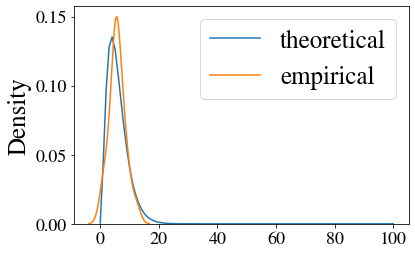

In [24]:
pvals = np.array([res.pval for res in test_ress[:]])
T_vs = np.array([res.T_v for res in test_ress[:]]);
L0s = np.array([res.L0 for res in test_ress[:]]);
chi_df = Cmat.shape[0]*N
kpidx = outlier_det(T_vs, 0.00)
print(
    f"The size is {np.mean(pvals[kpidx]<0.05):.3f} and "
    f"the mean of Tv is {np.mean(T_vs[kpidx]):.3f} and thoeretically it is {chi_df:.0f}. "
    f"L0 is {np.mean(L0s[kpidx]):.2f}."
     )

print(np.mean(kpidx))
xs = np.linspace(0.1, 100, 100)
theo_curvs_log = chi2.logpdf(xs, chi_df);
plt.plot(xs, np.exp(theo_curvs_log) , label="theoretical")
sns.kdeplot(T_vs[kpidx], label="empirical")
plt.legend()

# Back up 

post_reg

In [20]:
import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
if not logger.hasHandlers():
    ch = logging.StreamHandler() # for console. 
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    ch.setFormatter(formatter)
    logger.addHandler(ch)

In [84]:
from models.linear_model import LinearModel
from utils.misc import _update_params
class HDFOpt1(HDFOpt):
    def _post_reg(self):
        oracle_idx = torch.nonzero(torch.norm(self.est_Gam, dim=0))[:, 0]
        model_oracle = LinearModel(Y=self.opt_res.model.Y, 
                                   X=self.opt_res.model.X[:, oracle_idx], 
                                   Z=self.opt_res.model.Z,
                                   basis_mat=self.basis_mat, 
                                   sigma2=self.model_params.norminal_sigma2)
        
        model_oracle._linear_term_der()
        psX = model_oracle.lin_tm_der
        est_theta = torch.inverse(psX.T @ psX) @ psX.T @ self.Y
        est_alp = est_theta[:self.data_params.q]
        est_Gam = col_vec2mat_fn(est_theta[self.data_params.q:], self.bsp_params.N) * self.bsp_params.N**(1/2);
        self.est_Gam_oracle = est_Gam
        self.est_alp_oracle = est_alp
        self.model_oracle = model_oracle
    
    
    def _prepare_hypotest(self):
        """Calculate necessary quantities for hypo test
        """
        self._post_reg()
        est_alp, est_Gam = self.est_alp_oracle, self.est_Gam_oracle
        model = self.model_oracle
        d, q = self.data_params.d, self.data_params.q
        
        est_sigma2 = torch.mean((self.Y - model._obt_lin_tm(est_alp, est_Gam))**2)
        
        # get Q and Sig mat
        Q_mat = -model.log_lik_der2(est_alp, est_Gam)
        model.log_lik_der1(est_alp, est_Gam)
        Sig_mat = (model.log_lik_der1_vs.unsqueeze(-1) * model.log_lik_der1_vs.unsqueeze(1)).mean(axis=0) 
        
        M_idxs = np.delete(np.arange(d), self.sel_idx)
        
        
        self.hypo_utils = edict({})
        self.hypo_utils.Q_mat = Q_mat
        self.hypo_utils.Sig_mat = Sig_mat
        self.hypo_utils.est_sigma2 = est_sigma2
        self.hypo_utils.k = est_Gam.shape[1] - len(M_idxs)
        self.hypo_utils.est_sigma2 = est_sigma2
        
        
        
    def hypo_test(self, Cmat, ts=None, is_simpler=False, hypo_params={}):
        """
        Conduct hypothesis test based on the fitting resutls
        args:
            Cmat(np.ndarray): r x m matrix for the hypotest problem
            ts (np.ndarray): Hypotest is C Beta = ts, so ts is npts x r. Default to ts =0
            is_simpler(bool): only used for linear model, calculate the test stat in a simpler way to 
                              avoid too many matrix inverses.
            hypo_params(dict): other hypo parameters
                - svdinv_eps_Q: default to 1e-7, rtol for Q
                - svdinv_eps_Psi: default to 1e-7, rtol for Psi 
        """
        
        d = self.data_params.d
        n = self.data_params.n
        
        hypo_params_def = edict({
            "svdinv_eps_Q": 1e-7,
            "svdinv_eps_Psi": 1e-7,
        })
        hypo_params = _update_params(hypo_params, hypo_params_def, logger)
        hypo_params["Cmat"] = Cmat
        logger.info(f"hypo parmas is {hypo_params}.")
        self.hypo_params = hypo_params

        if ts is not None:
            if ts.ndim == 1:
                ts = ts[:, None]
            p1 = self.basis_mat.T @ self.basis_mat/self.basis_mat.shape[0]
            p2 = self.basis_mat.T @ ts/self.basis_mat.shape[0];
            p = torch.linalg.pinv(p1, hermitian=True) @ p2;
            vecp = p.T.flatten()/np.sqrt(self.bsp_params.N);
        else:
            vecp = 0
             
        
        
        self._prepare_hypotest()
        est_alp, est_Gam = self.est_alp_oracle, self.est_Gam_oracle
        
        est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(self.bsp_params.N)])
    
        # A mat
        Amat = torch.Tensor(self._get_Amat(self.hypo_utils.k, hypo_params.Cmat))
        
        # calculate Test stats
        Q_mat_inv = torch.linalg.pinv(self.hypo_utils.Q_mat, hermitian=True, rtol=hypo_params.svdinv_eps_Q)
        if is_simpler:
            Psi = self.hypo_utils.est_sigma2*Amat @ Q_mat_inv @ Amat.T/self.model_params.norminal_sigma2
        else:
            Psi = Amat @ Q_mat_inv @ self.hypo_utils.Sig_mat@ Q_mat_inv @ Amat.T
        Psi_inv = torch.linalg.pinv(Psi, hermitian=True, rtol=hypo_params.svdinv_eps_Psi)
        
        T_p1 = Amat @ est_theta - vecp
        T_v = T_p1 @ Psi_inv @ T_p1 * n 
        
        
        pval = chi2.sf(T_v, Cmat.shape[0]*self.bsp_params.N)
        #print(T_v, Cmat.shape[0]*self.bsp_params.N)
        
        hypo_test_res = edict()
        hypo_test_res.pval = pval
        hypo_test_res.T_v = T_v
        self.hypo_test_res = hypo_test_res
        return hypo_test_res